In [119]:
import torch
from torch import nn, optim
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings("ignore")

def score2(pm, pp, plant):
    plant_power = {
        1: 10,
        2: 10,
        3: 40,
        4: 50
    }
    threshold = plant_power[plant] * 0.03
    index = pm >= threshold
    return np.abs(pm[index] - pp[index]).sum() / (np.sum(index) * plant_power[plant])


class AttrProxy(object):
    def __init__(self, module, prefix):
        self.module = module
        self.prefix = prefix

    def __getitem__(self, i):
        return getattr(self.module, self.prefix + str(i))


class DNN(nn.Module):
    def __init__(self, param=None):
        super().__init__()
        if param is None:
            param = {"month": 4, "hour": 8, "n_layers": 3, "n_numerical": 6}
        self.param = param
        self.month_embed = nn.Embedding(12, param["month"])
        self.hour_embed = nn.Embedding(96, param["hour"])
        for i in range(param['n_layers']):
            if i == 0:
                self.add_module(
                    f'fc_{i}',
                    nn.Linear(param['hour']+param['month']+param['n_numerical'], 128)
                )
            else:
                self.add_module(f'fc_{i}', nn.Linear(128, 128))
        self.fc = AttrProxy(self, 'fc_')
        self.output = nn.Linear(128, 1)

    def forward(self, month, hour, numerical):
        m = self.month_embed(torch.tensor(month).long()).squeeze()
        h = self.hour_embed(torch.tensor(hour).long()).squeeze()
        numerical = torch.tensor(numerical).float()
        x = torch.cat((m, h, numerical), 1)
        for i in range(self.param['n_layers']):
            x = F.tanh(self.fc[i](x))
        x = F.tanh(self.output(x))
        return x

In [120]:
def load_dataset(plant):
    import datetime as dt
    train = pd.read_csv(f'../data/train_{plant}.csv', parse_dates=["时间"]).drop_duplicates().reset_index(drop=True)
    test = pd.read_csv(f'../data/test_{plant}.csv', parse_dates=["时间"])
    train.columns = ['time', 'irr', 'ws', 'wd', 'temp', 'pr', 'hm', 'mirr', 'power']
    test.columns = ['id', 'time', 'irr', 'ws', 'wd', 'temp', 'pr', 'hm']
    data = pd.concat([train, test])
    data['time'] = data['time'] + dt.timedelta(seconds=1.)
    return data

In [149]:
data = load_dataset(1)

In [150]:
data['month'] = LabelEncoder().fit_transform(data['time'].dt.month)
data['hour'] = LabelEncoder().fit_transform(data['time'].dt.hour * 60 + data['time'].dt.minute)

In [151]:
data['wd'] = (data['wd']-180) / 180

In [152]:
le = StandardScaler()

In [153]:
data.loc[data.id.isnull(), 'power'] = le.fit_transform(data[data.id.isnull()]['power'].values.reshape(-1, 1))

In [154]:
def generator(data, batch, shuffle=True):
#     data = data[data.power>0].copy()
    n = data.shape[0] // batch
    x = data[['hm', 'irr', 'pr', 'temp', 'wd', 'ws']].values
    m = data['month'].values.reshape(-1, 1)
    h = data['hour'].values.reshape(-1, 1)
    y = data['power'].values
    idx = np.array(range(data.shape[0]))
    if shuffle:
        np.random.shuffle(idx)
    for i in range(n):
        idx_i = idx[i*batch: (i+1)*batch]
        yield x[idx_i, :], h[idx_i], m[idx_i], y[idx_i]

In [157]:
param = {"month": 4, "hour": 12, "n_layers": 1, "n_numerical": 6}
model = DNN(param)
optimizer = optim.Adam(model.parameters(), 0.005)
loss_func = nn.MSELoss()
result = []

for ep in range(1):
    for idx, (x, h, m, y) in enumerate(generator(data[data.id.isnull()], 4, True)):
        optimizer.zero_grad()
        pred = model(m, h, x)
        y = torch.tensor(y).float().unsqueeze(1)
        loss = loss_func(pred, y)
        loss.backward()
        optimizer.step()
        result.append(loss.item())
        if idx % 5000 == 0 and idx > 0:
            l = np.mean(result[-5000:])
            print(f'epoch: {ep}, step: {idx}, loss: {l: .4f}')
            print(model.output.weight.sum().item())

epoch: 0, step: 5000, loss:  0.2368
0.36306333541870117
epoch: 0, step: 10000, loss:  0.2186
0.9010601043701172
epoch: 0, step: 15000, loss:  0.2158
1.1862902641296387


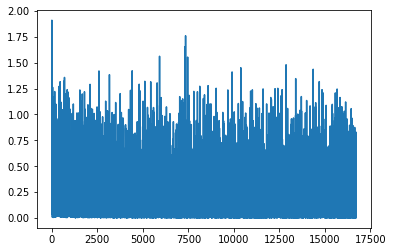

In [158]:
plt.plot(result)

In [159]:
pred = model(data['month'].values.reshape(-1, 1), data['hour'].values.reshape(-1, 1), data[['hm', 'irr', 'pr', 'temp', 'wd', 'ws']].values)

In [160]:
data['pred'] = pred.detach().numpy().reshape(-1)

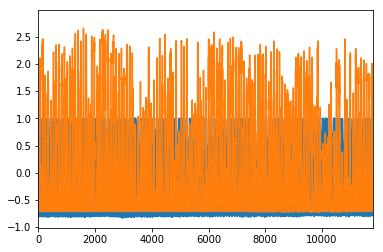

In [161]:
data['pred'].plot()
data['power'].plot()

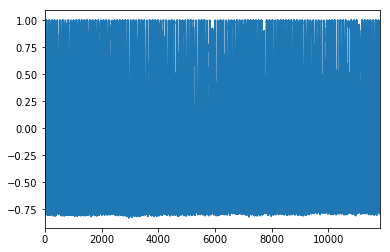

In [162]:
data['pred'].plot()

In [163]:
data['power'].describe()

count    6.685800e+04
mean     3.917205e-15
std      1.000007e+00
min     -7.290813e-01
25%     -7.117960e-01
50%     -7.044359e-01
75%      6.837889e-01
max      2.803443e+00
Name: power, dtype: float64

In [164]:
data['pred'].describe()

count    78666.000000
mean        -0.140977
std          0.752463
min         -0.830193
25%         -0.740625
50%         -0.680286
75%          0.870762
max          0.999528
Name: pred, dtype: float64

In [165]:
le.inverse_transform(data['pred'].reshape(-1, 1))

array([[-0.11348141],
       [-0.12106574],
       [-0.06538761],
       ..., 
       [ 0.02160274],
       [ 0.00994574],
       [-0.05503166]], dtype=float32)

In [166]:
le.inverse_transform(data[data.id.isnull()]['power'].reshape(-1, 1))

array([[-0.019333],
       [-0.021   ],
       [-0.022   ],
       ..., 
       [-0.057667],
       [-0.058333],
       [-0.058667]])

In [170]:
from sklearn.metrics import mean_squared_error

In [171]:
mean_squared_error(y_pred=le.inverse_transform(data[data.id.isnull()]['pred'].reshape(-1, 1)), 
                    y_true=le.inverse_transform(data[data.id.isnull()]['power'].reshape(-1, 1)))

1.8677059054671643

In [1]:
import keras

Using TensorFlow backend.
